# Naive Bayes (the easy way)

We'll start by using Naive Bayes for the sort of problem it's best suited for: building a spam classifier! Most of the code is just loading our training data into a pandas DataFrame that we can play with:

In [33]:
import os
import io
import numpy
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

def readFiles(path): # Read the two directories (spam / notspam)
    # Walk through each file in the directories
    for root, dirnames, filenames in os.walk(path): 
        for filename in filenames:
            # Contruct a path for each individual file
            path = os.path.join(root, filename) 

            inBody = False
            lines = []
            # Load the file
            f = io.open(path, 'r', encoding='latin1') 
            # Skip the first line (header) and read the body and add message into lines variable
            for line in f: 
                if inBody:
                    lines.append(line)
                elif line == '\n':
                    inBody = True
            f.close()
            message = '\n'.join(lines)
            # Returns the full path to the file and its body message
            yield path, message


def dataFrameFromDirectory(path, classification):
    rows = []
    index = []
    # Creates a dataframe object from files
    for filename, message in readFiles(path):
        rows.append({'message': message, 'class': classification})
        index.append(filename)

    return DataFrame(rows, index=index)

data = DataFrame({'message': [], 'class': []})

data = data.append(dataFrameFromDirectory('emails/spam', 'spam'))
data = data.append(dataFrameFromDirectory('emails/notspam', 'notspam'))


C:\Users\Kevin\AppData\Local\Temp\ipykernel_22376\2839175910.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataFrameFromDirectory('emails/spam', 'spam'))
C:\Users\Kevin\AppData\Local\Temp\ipykernel_22376\2839175910.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataFrameFromDirectory('emails/notspam', 'notspam'))


Let's have a look at that DataFrame:

In [34]:
data.head()

,message,class
emails/spam\00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",spam
emails/spam\00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,spam
emails/spam\00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,spam
emails/spam\00004.eac8de8d759b7e74154f142194282724,##############################################...,spam
emails/spam\00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,spam


Now we will use a CountVectorizer to split up each message into its list of words, and throw that into a MultinomialNB classifier. Call fit() and we've got a trained spam filter ready to go! It's just that easy.

In [40]:
# Convert each message body into list of words and how often they appear
vectorizer = CountVectorizer() 
counts = vectorizer.fit_transform(data['message'].values)

# Create the Naive Bayes model
classifier = MultinomialNB()
targets = data['class'].values
classifier.fit(counts, targets)

MultinomialNB()

Let's try it out:

In [41]:
examples = ['Free money now!!!', "Hi Bob, how about a game of golf tomorrow?"]
example_counts = vectorizer.transform(examples)
predictions = classifier.predict(example_counts)
predictions

array(['spam', 'notspam'], dtype='<U7')

That's pretty cool; we have a simple yet somewhat effective spam filter!

Now let's see how well Naive Bayes works on our problem of predicting vehicle speed classifications (slow or fast) based on the size and distance to an upcoming bump in the road. Again, we'll fabricate our data set exactly as we did before:

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.datasets import make_blobs

n_samples = 10000

# To generate our fabricated data set, we'll create two blobs of
# randomly distributed data at two corners (top left and bot right) of the graph...
centers = [(0.9, 0.05), (0.05, 0.94)]
X, y = make_blobs(n_samples=n_samples, n_features=2, cluster_std=0.4,
                  centers=centers, shuffle=False, random_state=42)

# Then filter out values that do not lie within [0,1]:
features = []
labels = []
for feature, label in zip(X, y):
    if (feature[0] >= 0 and feature[0] <= 1.0 and feature[1] >= 0 and feature[1] <= 1.0):
        features.append(feature)
        labels.append(label)

# And convert the results back into numpy arrays:
X = np.array(features)
y = np.array(labels)

Now let's create a Multinomial Naive Bayes classifier model, fit it to our data, and visualize the results:

C:\Users\Kevin\AppData\Local\Temp\ipykernel_22376\1873034917.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.scatter(X[:,0], X[:,1], c=y.astype(np.float))


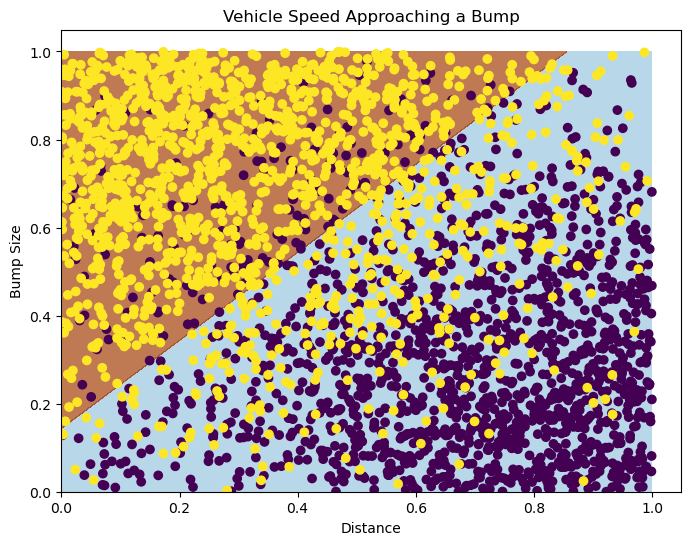

In [38]:
clf = MultinomialNB()
clf.fit(X, y)

def plotPredictions(clf):
    xx, yy = np.meshgrid(np.arange(0, 1.0, 0.001),
                     np.arange(0, 1.0, 0.001))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(8, 6))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:,0], X[:,1], c=y.astype(np.float))
    plt.xlabel('Distance')
    plt.ylabel('Bump Size')
    plt.title("Vehicle Speed Approaching a Bump")
    plt.show()
    
plotPredictions(clf)

It seems to have found just about the same linear relationship that our logistic regression model found. Data set that have simple patterns are usually best served with simpler models, it turns out. So while you could use Naive Bayes for this problem, it may be a bit of overkill. Let's measure its accuracy:

In [39]:
from sklearn.model_selection import cross_val_score

fold_scores = cross_val_score(clf, X, y, cv=5)
print (fold_scores)
print (np.mean(fold_scores))

[0.85245902 0.8295082  0.83251232 0.82758621 0.81773399]
0.831959945086005


Interestingly, logistic regression actually out-performs it slightly. But the results are still decent, and close enough to logistic regression's results that there may not be a real difference.